In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML

np.set_printoptions(suppress=True)

import bayesflow as bf
import tensorflow as tf

from functools import partial
from numba import njit

from bayesflow.simulation import Prior, Simulator, GenerativeModel

# Vicsek model: partial pooling

This notebook provides a baseline, hierarchical estimate for parameters in the Vicsek model.

Simple case for hyperprior:

\begin{align}
    z_r &\sim \mathcal{N}(0, 1),\\
    \mu_v &\sim \mathcal{N}(0, 1),\\
    z_v &\sim \mathcal{N}(0, 1).
\end{align}

In [4]:
@njit
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [9]:
param_names = [r'$r$', r'$\mu_v$']

@njit
def hyperprior_fun():
    """
    Sample prior parameters for the agent group, 
    i.e., base scale of sensing radius (r) and walking speed (v). 
    
    Returns
    -------
    Sampled priors as a NumPy array.
    """
    
    # Hypermean for velocity
    mu_v = np.random.normal(0., 1.)
    
    z_r = np.random.normal(0., 1.)
    
    # Bounding using Sigmoid
    r = sigmoid(z_r)
    
    return np.array([mu_v, r], dtype=np.float32)

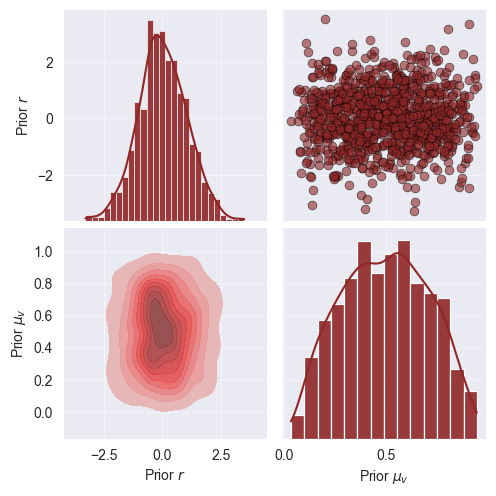

In [10]:
test_prior = Prior(prior_fun=hyperprior_fun)
f = bf.simulation.plot_prior2d(test_prior, param_names=param_names, n_samples=1000)

In [12]:
@njit
def initialize_agents(
    num_agents = 12,
    boundary_size = 10.,
):
    """
    Initialize agent positions and directions.
    
    Parameters
    ----------
    num_agents      : int, default: 12
        Number of agents to initialize. 
    boundary_size   : float, default: 10.0
        Size of the boundary (in meters).
    
    Returns
    -------
    positions      : np.ndarray of shape (num_agents, 2)
        Initial positions of the agents.
    directions      : np.ndarray of shape (num_agents, )
        Initial directions of the agents. 
    """
    
    positions = np.random.random(size=(num_agents, 2)).astype(np.float32) * boundary_size
    directions = np.random.random(size=num_agents) * np.pi
    
    # Unpack hypers
    hypers = hyperprior_fun()
    mu_v, r = hypers[0], hypers[1]
    
    # Sample individual radii and velocities (they will now be different)
    theta = np.empty((num_agents, 2), dtype=np.float32)
    
    for i in range(num_agents):
        theta[i, 0] = r
        theta[i, 1] = sigmoid(np.random.normal(mu_v, 1))      
    
    return positions, directions, theta, hypers

In [38]:
positions, directions, theta, hypers = initialize_agents(num_agents=12, boundary_size=10)

In [13]:
@njit
def simulator_fun(
    theta=None,
    num_agents=12,
    num_timesteps=100,
    boundary_size=10.0,
):
    """
    Simulate the movement trajectory of the agent, 
    as governed by the Vicsek model.
    
    Parameters
    ----------
    theta : np.ndarray of shape (2, )
        Sampled priors for the model, including the 
        base sensing radius (r) and walking speed (v)
        of the agents.
    num_agents     : int, default: 12
        Number of agents to simulate.
    num_timesteps   : int, default: 100
        Number of timesteps to simulate.
    boundary_size   : float, default: 10.0
        Size of the simulation boundary (in meters).
    
    Returns
    -------
    A concatenated NumPy array of combined trajectory 
    and direction of the agents as timeseries.
    """
    
    np.random.seed(42)
    
    # Initialize positions and directions for each agent
    positions, directions, theta, hypers = initialize_agents(num_agents, boundary_size)
    
    r, v = theta[:, 0], theta[:, 1]
    
    # Scale radius with half of boundary size (for realism)
    radius = r * boundary_size * 0.5

    # Store trajectories and headings
    paths = np.zeros((num_timesteps + 1, num_agents, 2))
    headings = np.zeros((num_timesteps + 1, num_agents, 1))


    paths[0] = positions
    headings[0] = directions[:, np.newaxis]

    # Loop over each timestep
    for t in range(num_timesteps):
        # For each timestep, initialize directions for the agents
        new_directions = np.zeros(num_agents)
        
        # For each agent, collect neighbors within its sensing range
        for i in range(num_agents):
            
            neighbors = []
            # If there are any neighbors, average over their directions 
            # and assign it as the new direction. 
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < radius[i]:
                    neighbors.append(directions[j])
            if neighbors:
                # This is incorrect, because of wrap-around radians.
                # avg_direction = np.mean(np.array(neighbors))
                
                # This is correct
                # Separate the direction into Cartesian components
                dir_x = np.cos(directions)
                dir_y = np.sin(directions)
                # Averaging the direction
                avg_dir_x = np.mean(dir_x)
                avg_dir_y = np.mean(dir_y)
                # Convert the direction back to radians
                avg_direction = np.arctan2(avg_dir_y, avg_dir_x)
                
                new_directions[i] = avg_direction + np.random.uniform(-0.01, 0.01)
            else:
                new_directions[i] = directions[i]

        directions = np.copy(new_directions)
            
            # Update position upon new direction
        positions[:,0] += v * np.cos(directions)
        positions[:,1] += v * np.sin(directions)
        
        # Assumes periodic boundary condition (for now)
        positions = np.mod(np.copy(positions), boundary_size)

        # Add timestamps to trajectories and headings
        paths[t + 1] = np.copy(positions)
        headings[t + 1] = np.copy(directions[:, np.newaxis])

    return np.concatenate((paths, headings), axis=-1)

Querying the simulated results directly to the prior samples.

In [14]:
check_priors = hyperprior_fun()

check_simulator = simulator_fun()
check_simulator

array([[[3.7454012 , 9.5071429 , 1.43278611],
        [7.31993914, 5.98658502, 2.46670303],
        [1.56018645, 1.5599452 , 0.62729369],
        ...,
        [4.31945026, 2.91229129, 2.98101183],
        [6.11852884, 1.39493868, 3.0336225 ],
        [2.92144656, 3.66361856, 2.53965517]],

       [[3.77718847, 9.7360042 , 1.43278611],
        [7.27231977, 6.76270908, 1.63207487],
        [1.53793065, 1.91035546, 1.63422467],
        ...,
        [4.29278551, 3.31180755, 1.63744008],
        [5.58723818, 1.45252616, 3.0336225 ],
        [2.89578495, 4.05708321, 1.63592371]],

       [[3.80897574, 9.9648655 , 1.43278611],
        [7.14777485, 7.53025369, 1.73165837],
        [1.48447937, 2.25737944, 1.72362293],
        ...,
        [4.23290278, 3.70770944, 1.72091489],
        [5.05594752, 1.51011365, 3.0336225 ],
        [2.83050784, 4.44594289, 1.73711368]],

       ...,

       [[8.04472475, 1.36440756, 1.83416527],
        [7.32680835, 9.4962811 , 1.8377317 ],
        [2.45642585, 4

Make sure that the simulation outcome is stable

In [15]:

output1 = simulator_fun()
output2 = simulator_fun()

print (output1 == output2)

[[[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 ...

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]]


In [16]:
check_priors

array([1.1260368 , 0.55911225], dtype=float32)

In [17]:
average_heading = np.mean(check_simulator[:,:,-1], axis=1)
global_average_heading = np.mean(average_heading)
global_average_heading

1.835681298251763

<Axes: >

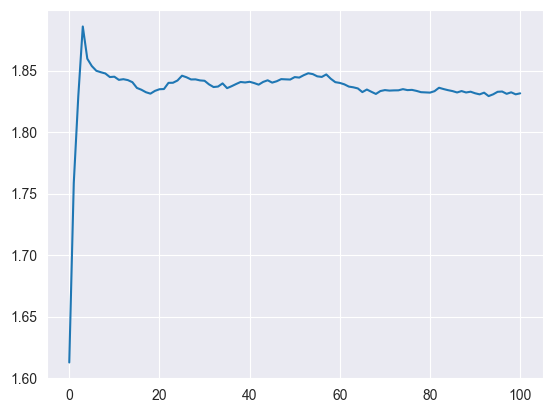

In [18]:
sns.lineplot(data=average_heading)

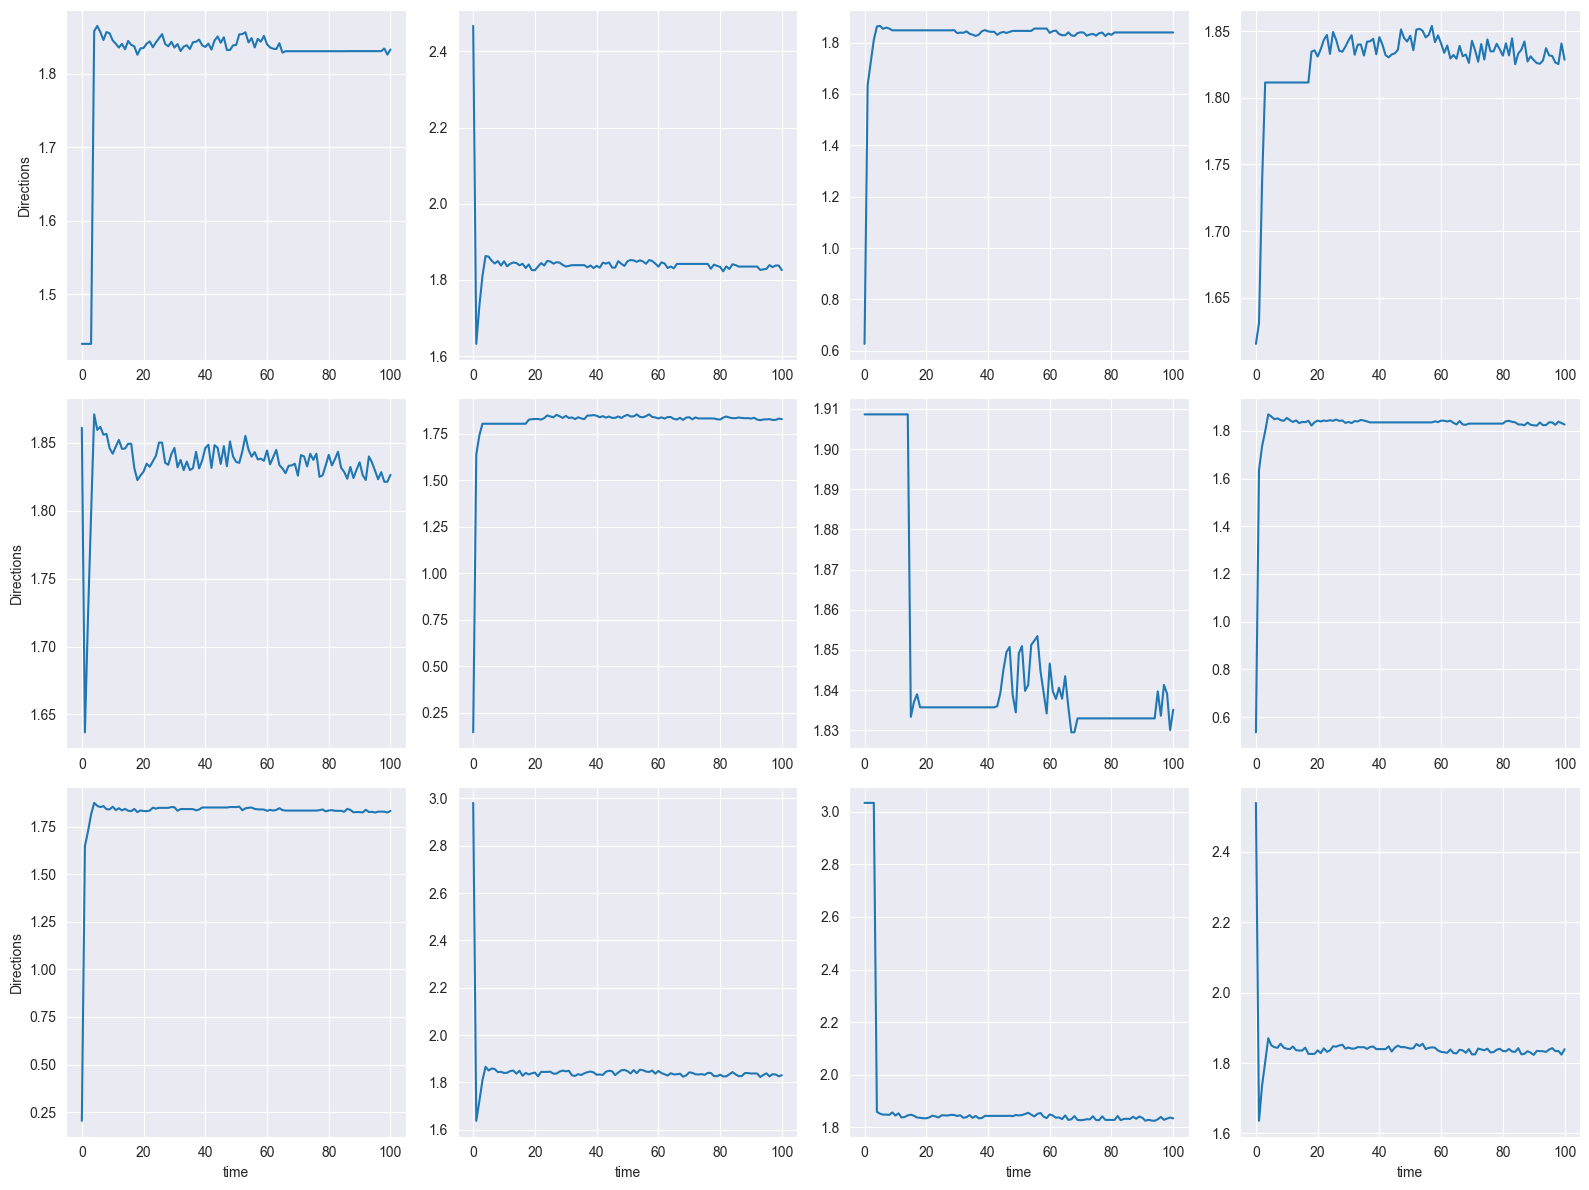

In [19]:
fig, axarr = plt.subplots(3, 4, figsize=(16, 12))

for i, ax in enumerate(axarr.flat):
    sns.lineplot(check_simulator[:,i,-1], ax=ax)
    
    if i >= 8:
        ax.set_xlabel("time")
    if i % 4 == 0:
        ax.set_ylabel("Directions")
    
fig.tight_layout()

# Generative Model

In [20]:
prior = Prior(prior_fun=hyperprior_fun)

simulator = Simulator(simulator_fun=simulator_fun)

model = GenerativeModel(prior=prior, simulator=simulator, simulator_is_batched=False, name="Vicsek")

INFO:root:Performing 2 pilot runs with the Vicsek model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [21]:
def animate(paths, boundary_size = 10.0):
    
    positions = paths[:,:,0:2]
    directions = paths[:,:,2:]
    
    fig, ax = plt.subplots(figsize=(4, 4))


    def update(frame):
        ax.clear()
        quiver = ax.quiver(positions[frame, :, 0], positions[frame, :, 1], np.cos(directions[frame]), np.sin(directions[frame]))
        quiver.set_offsets(positions[frame])
        quiver.set_UVC(np.cos(directions[frame]), np.sin(directions[frame]))
        ax.set_xlim(0, boundary_size)
        ax.set_ylim(0, boundary_size)
        return quiver,

    a = animation.FuncAnimation(fig, update, frames=len(positions), blit=True, repeat=False)
    plt.title("Vicsek Model")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    return a

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


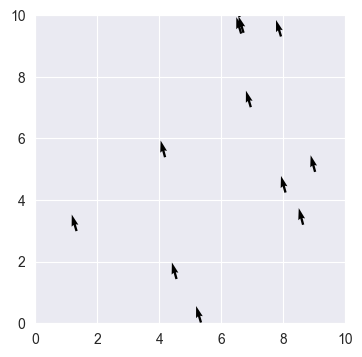

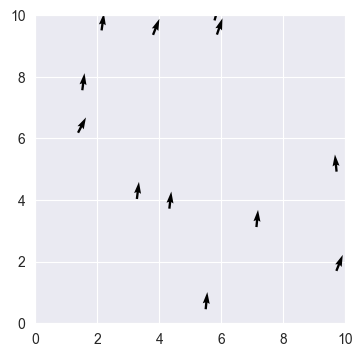

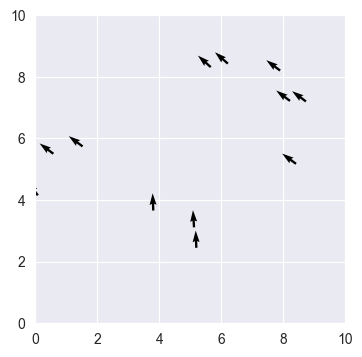

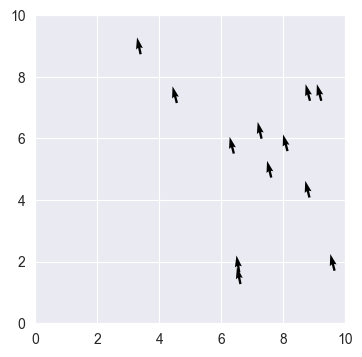

In [13]:
pushforward_sim = model(4)['sim_data']

for i in range(pushforward_sim.shape[0]):
    a = animate(pushforward_sim[i])
    m = HTML(a.to_jshtml())

# Configurator

In [22]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32)
    x = input_dict['sim_data'] / 10. 
    if transpose:
        x = np.transpose(x, (0, 2, 1, 3))
    output_dict['summary_conditions'] = x.astype(np.float32)
    return output_dict

In [11]:
class StackedLSTM(tf.keras.Model):
    def __init__(self, summary_dim=32, lstm_units=512, hidden_units=512, dropout=0.05):
        super().__init__()
        
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_units, activation="mish"),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(hidden_units // 16)
        ])
        self.lstm = tf.keras.layers.LSTM(lstm_units, dropout=dropout)
        self.projector = tf.keras.layers.Dense(summary_dim)
        
    def call(self, x, **kwargs):
        
        old_shape = tf.shape(x)
        x = tf.reshape(x, shape=(old_shape[0], old_shape[1], -1))
        embeddings = self.mlp(x, **kwargs)
        rep = self.lstm(embeddings, **kwargs)
        proj = self.projector(rep)
        return proj

# Neural Approximator

In [24]:
# This one generalizes over different numbers of agents
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=128)),
    bf.networks.SetTransformer(num_inducing_points=None, input_dim=128, summary_dim=64)
])

In [25]:
# Original inference net and amortizer
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=2, 
    num_coupling_layers=5,
    coupling_design="affine",
    coupling_settings={
        'kernel_regularizer': None,
        'dropout_prob': 0.0
    }
)


amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)


trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [36]:
inference_net = bf.helper_networks.ConfigurableMLP(
    input_dim=2, 
    num_hidden=5,
    dropout_rate=0.0
)

amortizer = bf.amortizers.AmortizedPointEstimator(
    summary_net=summary_net, inference_net=inference_net
)

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Online Training

In [37]:
history = trainer.train_online(epochs=5, batch_size=32, iterations_per_epoch=500)

Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

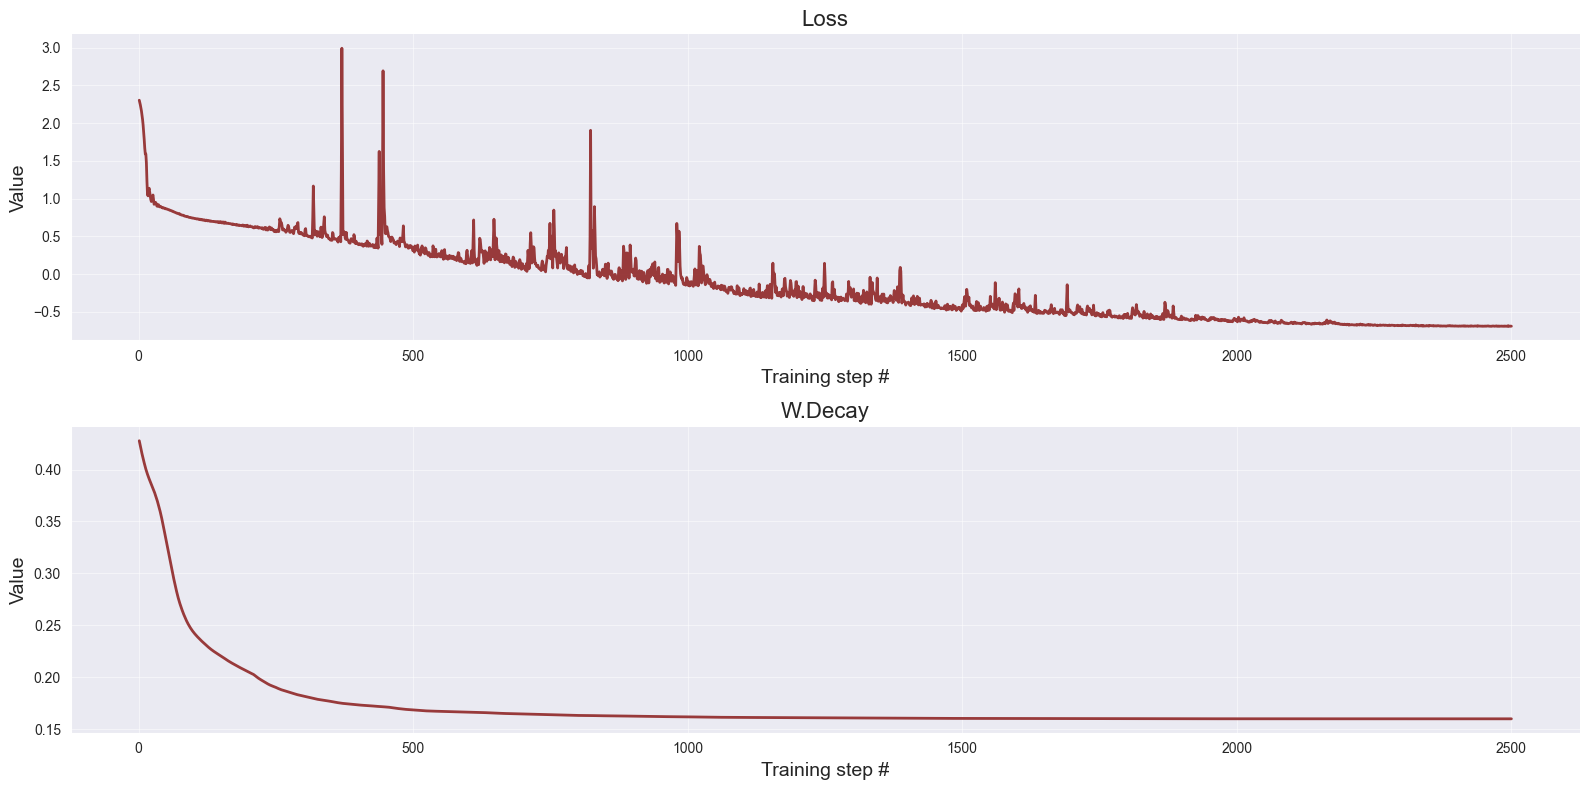

In [27]:
f = bf.diagnostics.plot_losses(history)

# Validation

In [28]:
validation_sim = model(400)
validation_configured = configurator(validation_sim)

In [29]:
post_samples = amortizer.sample(validation_configured, n_samples=1000)
prior_samples = validation_configured["parameters"]

# Parameter Recovery

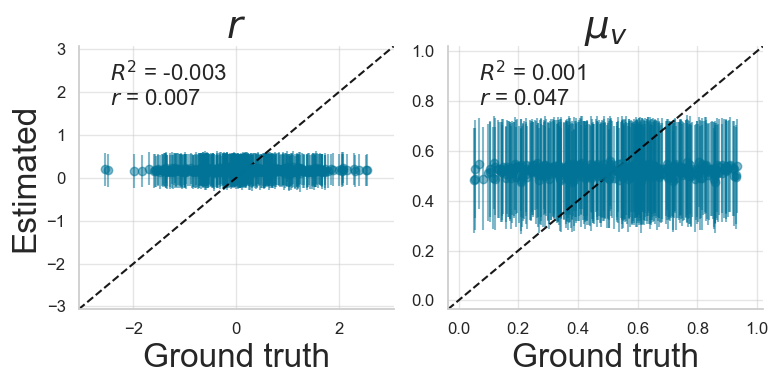

In [31]:
sns.set(rc={'axes.facecolor':'#FFFFFF00', 'figure.facecolor':'#FFFFFF00'})
sns.set_style('whitegrid')

g = bf.diagnostics.plot_recovery(
    post_samples=post_samples, 
    prior_samples=prior_samples, 
    param_names=param_names,
    label_fontsize=24,
    title_fontsize=28,
    color="#007396"
)

The drift $v$ shows near-perfect recovery, followed by the noise parameter $\eta$.

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


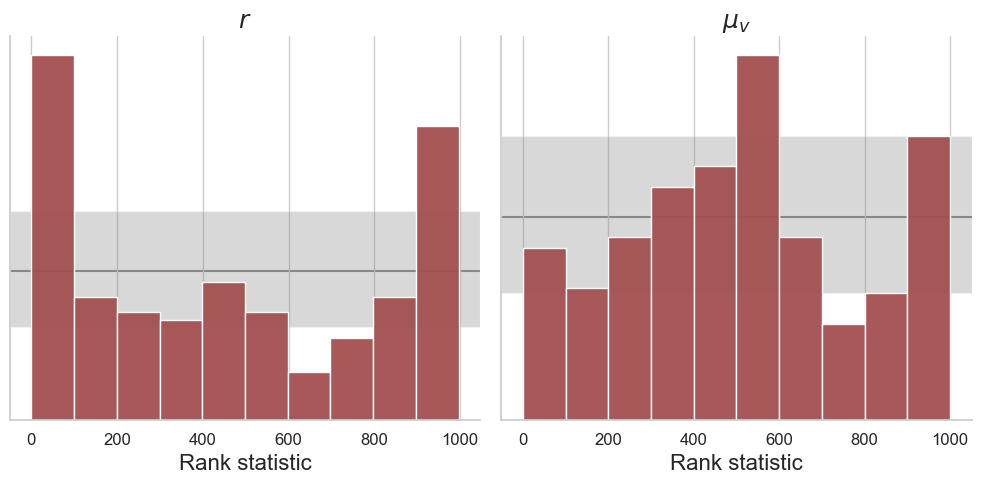

In [32]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, num_bins=10)

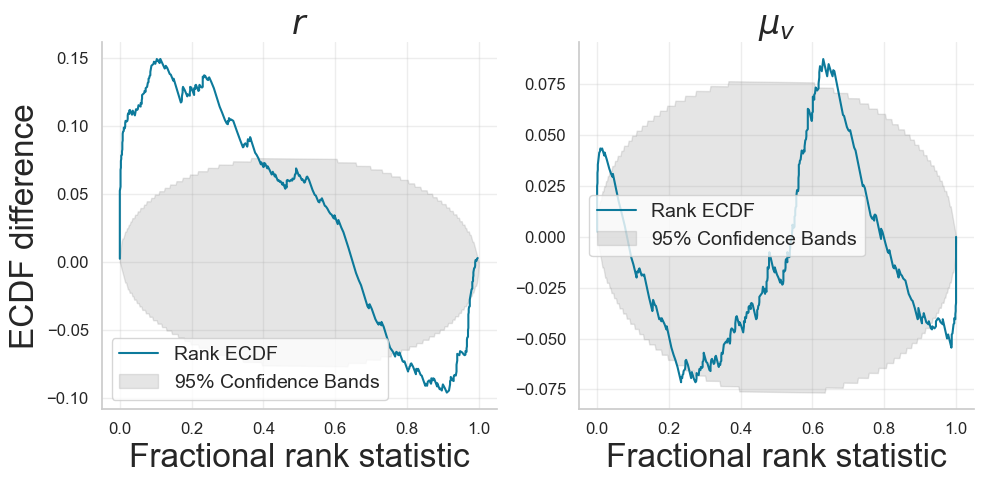

In [33]:
e = bf.diagnostics.plot_sbc_ecdf(
    post_samples=post_samples, 
    prior_samples=prior_samples, 
    param_names=param_names, 
    difference=True,
    title_fontsize=24,
    label_fontsize=24,
    rank_ecdf_color="#007396"
)

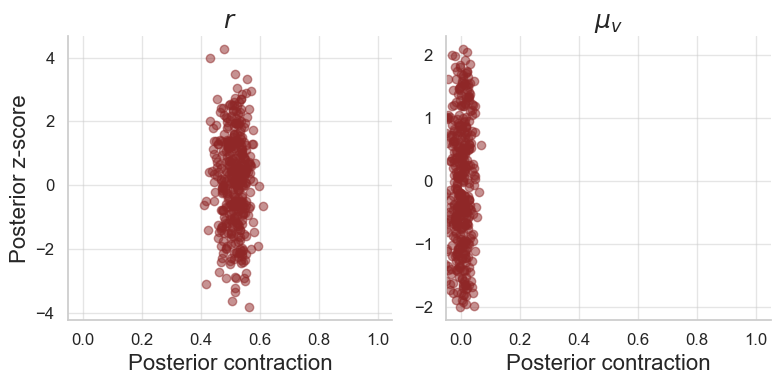

In [34]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

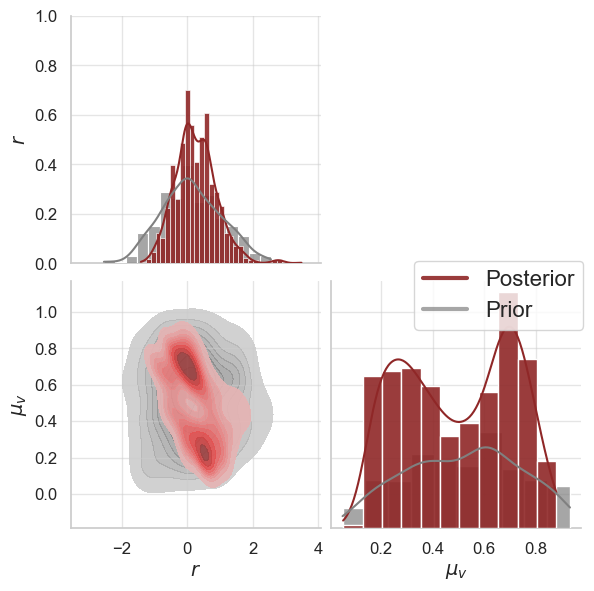

In [35]:
d = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[1], prior_draws=prior_samples, param_names=param_names)